# Figure B3: Sensitivity to P2P transaction frictions

This notebook reproduces **Figure B3** in Appendix B of the paper  
*“Asynchronous Implementation of the Travel Rule and Transitional Risks in Crypto-Asset Regulation.”*

## Purpose
The analysis evaluates the robustness of the results to assumptions about the minimum transaction friction in the P2P channel.

By varying the lower bound of P2P friction, the exercise tests whether the main results hinge on how easily agents can transition into peer-to-peer transactions.

## Output
The notebook generates `Figure_B3_kC.png`, showing average illicit activity during the transition period (t = 6–35).

The qualitative ranking of scenarios (S, A, A′) is preserved regardless of P2P friction assumptions.

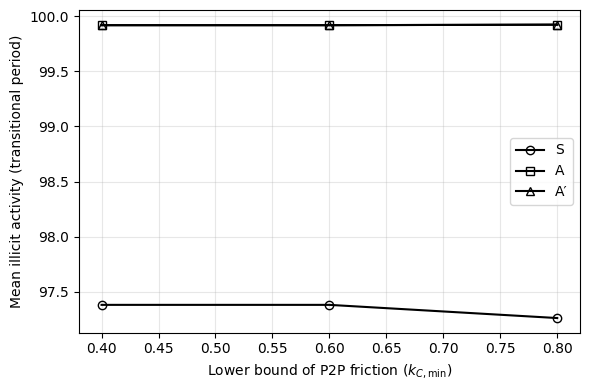

In [ ]:
# ============================================
# Appendix B - Figure B3
# Robustness to P2P friction lower bound (k_C_min)
# ============================================

import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Scenario parameters
# ----------------------------
def scenario_params(scenario):
    if scenario == "S":
        Tj = np.array([6, 6, 6, 6, 6, 6])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "A":
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.04, 0.04])
    elif scenario == "Aprime":
        Tj = np.array([6, 6, 18, 18, 36, 36])
        rho = np.array([0.06, 0.06, 0.05, 0.05, 0.015, 0.015])
    else:
        raise ValueError("Unknown scenario")
    return Tj, rho


# ----------------------------
# Core ABM (Y only, k_C_min variable)
# ----------------------------
def run_one(
    scenario,
    seed,
    *,
    kC_min,
    lam=5,
    F=6,
    T=60,
    N=100,
):
    rng = np.random.default_rng(seed)

    Tj, rho = scenario_params(scenario)

    J = 6
    L = np.zeros(J)
    R = np.zeros(J)
    Y = np.zeros(T)

    for t in range(T):
        for j in range(J):
            if t >= Tj[j]:
                L[j] = 1
                R[j] = min(1.0, R[j] + rho[j])

        # sunrise gap
        s_gap = 1.0 - np.mean(L * R)

        pA = np.clip(0.18 - 0.4 * s_gap, 0, 1)
        pB = np.clip(0.08 - 0.5 * s_gap, 0, 1)
        pC = 0.02

        # P2P friction declines but bounded below
        kC = max(kC_min, 1.0 - 0.01 * t)

        costA = pA * F + 0.2
        costB = pB * F + 0.05
        costC = pC * F + kC
        costs = np.array([costA, costB, costC])

        probs = np.exp(-lam * costs)
        probs /= probs.sum()

        choices = rng.choice([0, 1, 2], size=N, p=probs)
        caught = rng.random(N) < np.where(
            choices == 0, pA, np.where(choices == 1, pB, pC)
        )

        Y[t] = N - caught.sum()

    return Y


# ----------------------------
# Transitional mean Y
# ----------------------------
def transitional_mean_Y(
    scenario,
    *,
    kC_min,
    Rruns,
    lam=5,
    F=6,
    t1=6,
    t2=35,
    seed0=40000,
):
    vals = []
    for r in range(Rruns):
        Y = run_one(
            scenario,
            seed=seed0 + r,
            kC_min=kC_min,
            lam=lam,
            F=F,
        )
        vals.append(Y[t1 : t2 + 1].mean())
    return np.mean(vals)


# ----------------------------
# Figure B3
# ----------------------------
def make_figure_B3(
    *,
    kC_grid=(0.4, 0.6, 0.8),
    Rruns=120,
    savepath="Figure_B3_kC.png",
):
    Y_S, Y_A, Y_Ap = [], [], []

    for kC in kC_grid:
        Y_S.append(transitional_mean_Y("S", kC_min=kC, Rruns=Rruns))
        Y_A.append(transitional_mean_Y("A", kC_min=kC, Rruns=Rruns))
        Y_Ap.append(transitional_mean_Y("Aprime", kC_min=kC, Rruns=Rruns))

    fig, ax = plt.subplots(figsize=(6, 4))

    ax.plot(
        kC_grid, Y_S,
        marker="o",
        linestyle="-",
        color="black",
        markerfacecolor="none",
        markeredgecolor="black",
        label="S",
    )
    ax.plot(
        kC_grid, Y_A,
        marker="s",
        linestyle="-",
        color="black",
        markerfacecolor="none",
        markeredgecolor="black",
        label="A",
    )
    ax.plot(
        kC_grid, Y_Ap,
        marker="^",
        linestyle="-",
        color="black",
        markerfacecolor="none",
        markeredgecolor="black",
        label="A′",
    )

    ax.set_xlabel("Lower bound of P2P friction ($k_{C,\\min}$)")
    ax.set_ylabel("Mean illicit activity (transitional period)")
    ax.legend()
    ax.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(savepath, dpi=200)
    plt.show()


# ----------------------------
# Run
# ----------------------------
if __name__ == "__main__":
    make_figure_B3()
